# Deep Learning Term Project for ECG (DIL700)

## Loading dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

# The dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

In [2]:
normal_df=pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df=pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)

# Size overview

In [3]:
normal_df.shape

(4046, 188)

In [4]:
abnormal_df.shape

(10506, 188)

# First rows

In [5]:
normal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
abnormal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [7]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [8]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

# Show examples

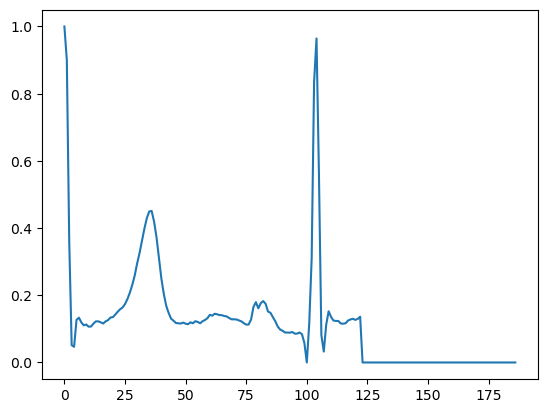

In [9]:
# Instance 0 from normal dataset
ecg_example = normal_df.iloc[0,:187]
plt.plot(ecg_example)

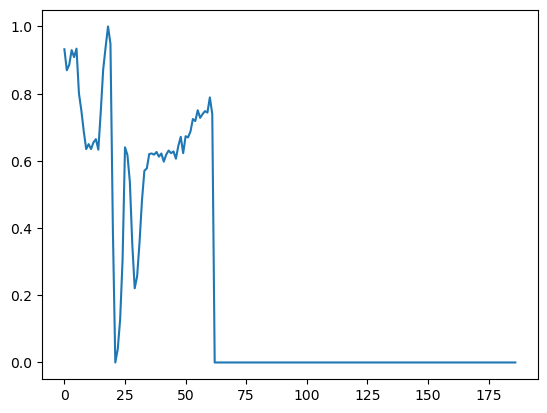

In [10]:
# # Instance 0 from abnormal dataset
ecg_example = abnormal_df.iloc[0,:187]
plt.plot(ecg_example)

In [11]:
def plot_ecg_examples(df, n_examples=5):    

    # choose 5 random instances from the filtered DataFrame
    random_instances = df.sample(n=n_examples, random_state=42)

    return random_instances

In [12]:
samples = list()
samples.append(plot_ecg_examples(normal_df, 10))
samples.append(plot_ecg_examples(abnormal_df, 10))

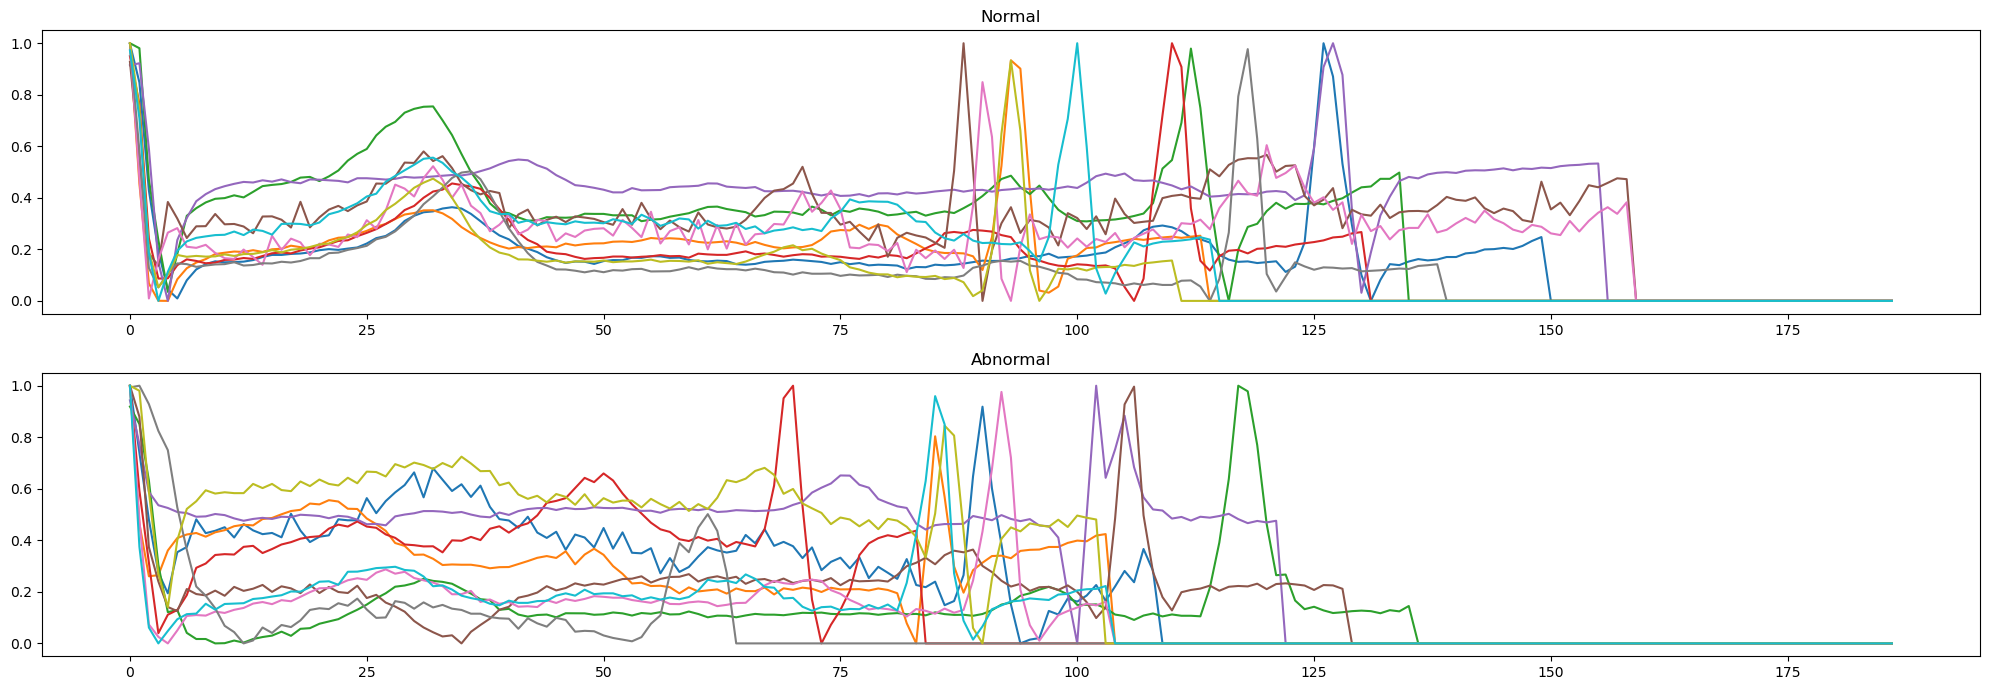

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(20, 7))
titles = ['Normal', 'Abnormal']
for i in range(len(samples)):
    ax = axs.flat[i]
    vals = samples[i].values[:,:-1].transpose()
    ax.plot(samples[i].values[:,:-1].transpose())
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()

# Heatmap of the two classes

In [14]:
# Which value in the range from 0 to 1 the most used at that position

# Trying some basics statistics

In [15]:
# Testing: has 22 times col with value 0 --> "duration" of 165 element with non zero values (from 187 total values)
sample_no_label = normal_df.loc[2][0:187]
sample_no_label[160:187]

160    0.227598
161    0.238842
162    0.249063
163    0.254514
164    0.270187
165    0.000000
166    0.000000
167    0.000000
168    0.000000
169    0.000000
170    0.000000
171    0.000000
172    0.000000
173    0.000000
174    0.000000
175    0.000000
176    0.000000
177    0.000000
178    0.000000
179    0.000000
180    0.000000
181    0.000000
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: 2, dtype: float64

In [16]:
# Mean value of duration (points where the signal is not zero)

def mean_dur(df, sample):
    
    # last col contains label, exclude element in col 187
    sample_no_label = df.loc[sample][0:187]
    
    # count for empty cols from the back
    flag = True
    i = 0
    while flag:
        col_val = sample_no_label[186-i]
        # Stop on first non zero element
        if col_val != 0:
            flag = False
        else:
            i = i + 1
            
    duration = 187 - i
            
    return duration

In [17]:
print(mean_dur(normal_df, 2))

165


In [18]:
normal_durs = list()
for i in range(len(normal_df)):
    normal_durs.append(mean_dur(normal_df, i))
# cross check
print(len(normal_durs))

4046


In [19]:
abnormal_durs = list()
for i in range(len(abnormal_df)):
    abnormal_durs.append(mean_dur(abnormal_df, i))
# cross check
print(len(abnormal_durs))

10506


In [20]:
def average(lst):
    return round(sum(lst)/len(lst),2)
    
print(f'Average durations: Normal {average(normal_durs)} Abnormal: {average(abnormal_durs)}')

Average durations: Normal 130.44 Abnormal: 112.65


In [21]:
print(f'Max durations: \t Normal {max(normal_durs)} \t Abnormal: {max(abnormal_durs)}')
print(f'Min durations: \t Normal {min(normal_durs)} \t Abnormal: {min(abnormal_durs)}')

Max durations: 	 Normal 186 	 Abnormal: 186
Min durations: 	 Normal 62 	 Abnormal: 51


# Visualization of forming clusters

# kPCA

In [22]:
from sklearn.decomposition import KernelPCA

In [23]:
normal_df_noclass = normal_df.iloc[:,:187]
abnormal_df_noclass = abnormal_df.iloc[:,:187]

In [24]:
normal_pca_array = normal_df_noclass.to_numpy()
abnormal_pca_array = abnormal_df_noclass.to_numpy()

# Linear PCA

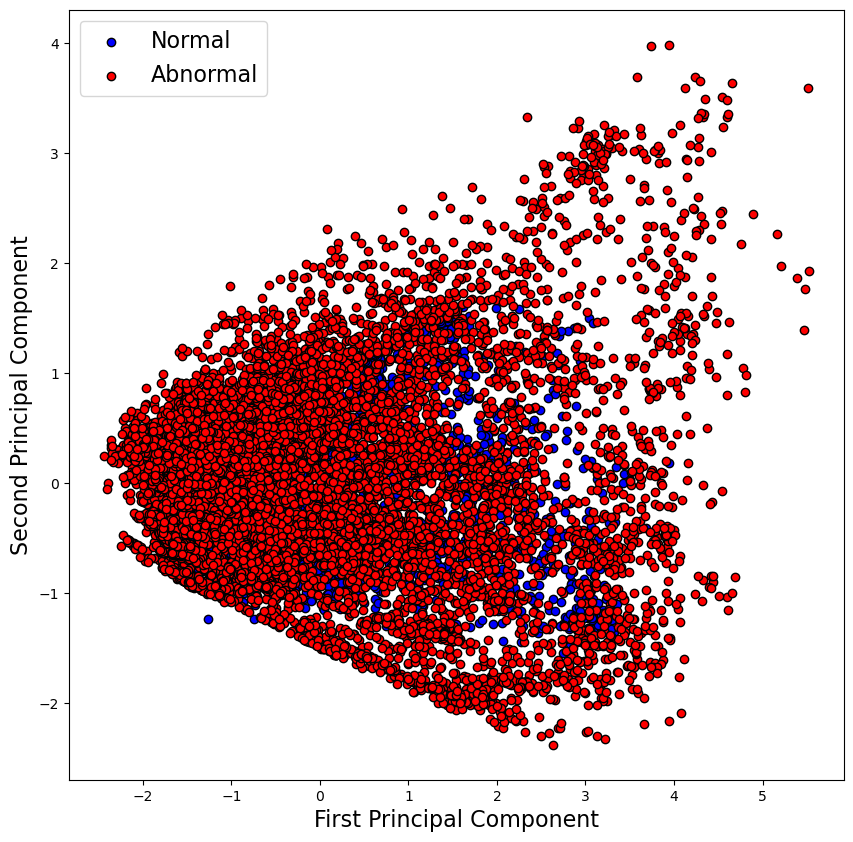

In [25]:
%matplotlib inline

# Find the first 2 principal components for both the datasets
pca1 = KernelPCA(kernel="linear", n_components=3, random_state=0)
normal_pca = pca1.fit_transform(normal_pca_array)
pca2 = KernelPCA(kernel="linear", n_components=3, random_state=0)
abnormal_pca = pca2.fit_transform(abnormal_pca_array)

# Figure size
plt.figure(figsize=(10,10))

colors = ['b', 'c', 'y', 'm', 'r']

# Plot the first two components
normal = plt.scatter(normal_pca[:, 0], normal_pca[:, 1], edgecolors='#000000', label="normal", color=colors[0])
abnormal = plt.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], edgecolors='#000000', label="abnormal", color=colors[4])
plt.xlabel("First Principal Component", fontsize=16)
plt.ylabel("Second Principal Component", fontsize=16)
plt.legend((normal, abnormal),
           ('Normal', 'Abnormal'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=16)

# Show the plot
plt.show()

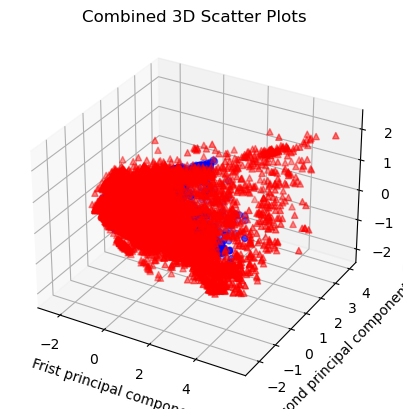

In [26]:
%matplotlib inline

#### %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

# create two 3D scatter plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o') #, marker='o'
ax.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], abnormal_pca[:, 2], c='r', marker='^') #, marker='^'

# set the axis labels
ax.set_xlabel('Frist principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# set the plot title
ax.set_title('Combined 3D Scatter Plots')

# show the plot
plt.show()

# RBF PCA

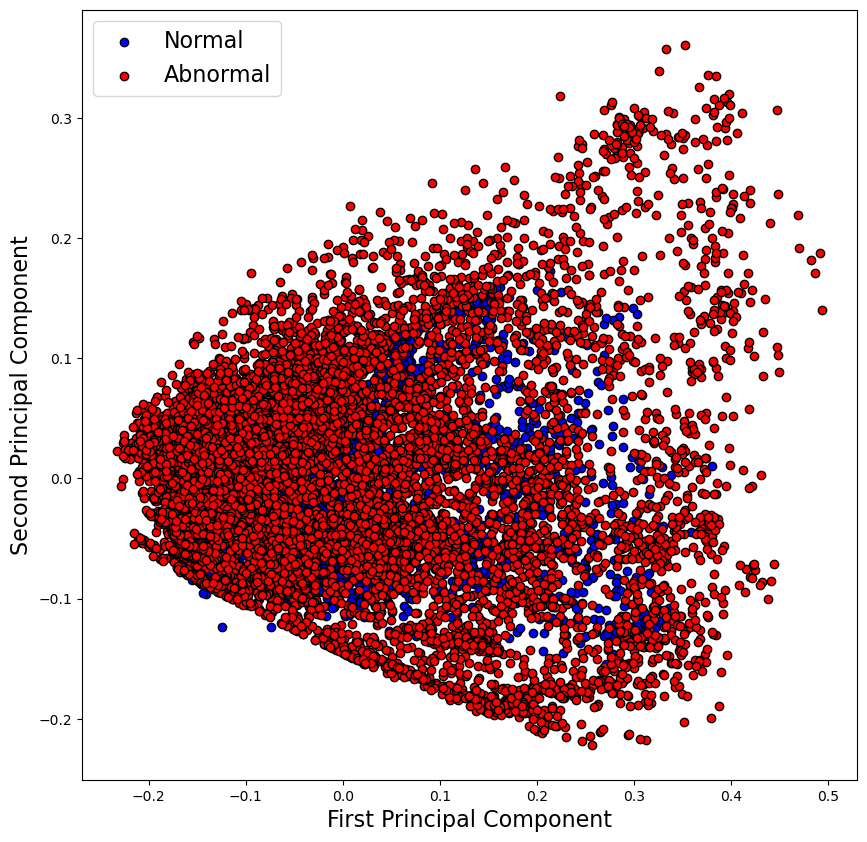

In [27]:
%matplotlib inline

# Find the first 2 principal components for both the datasets
pca3 = KernelPCA(kernel="rbf", n_components=3, random_state=0)
normal_pca = pca3.fit_transform(normal_pca_array)
pca4 = KernelPCA(kernel="rbf", n_components=3, random_state=0)
abnormal_pca = pca4.fit_transform(abnormal_pca_array)

# Figure size
plt.figure(figsize=(10,10))

colors = ['b', 'c', 'y', 'm', 'r']

# Plot the first two components
normal = plt.scatter(normal_pca[:, 0], normal_pca[:, 1], edgecolors='#000000', label="normal", color=colors[0])
abnormal = plt.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], edgecolors='#000000', label="abnormal", color=colors[4])
plt.xlabel("First Principal Component", fontsize=16)
plt.ylabel("Second Principal Component", fontsize=16)
plt.legend((normal, abnormal),
           ('Normal', 'Abnormal'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=16)

# Show the plot
plt.show()

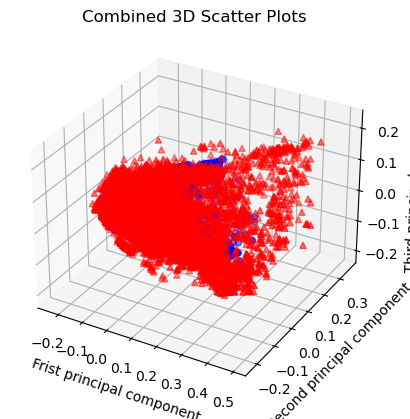

In [28]:
%matplotlib inline

#### %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

# create two 3D scatter plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o') #, marker='o'
ax.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], abnormal_pca[:, 2], c='r', marker='^') #, marker='^'

# set the axis labels
ax.set_xlabel('Frist principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# set the plot title
ax.set_title('Combined 3D Scatter Plots')

# show the plot
plt.show()

# SIGMOID PCA

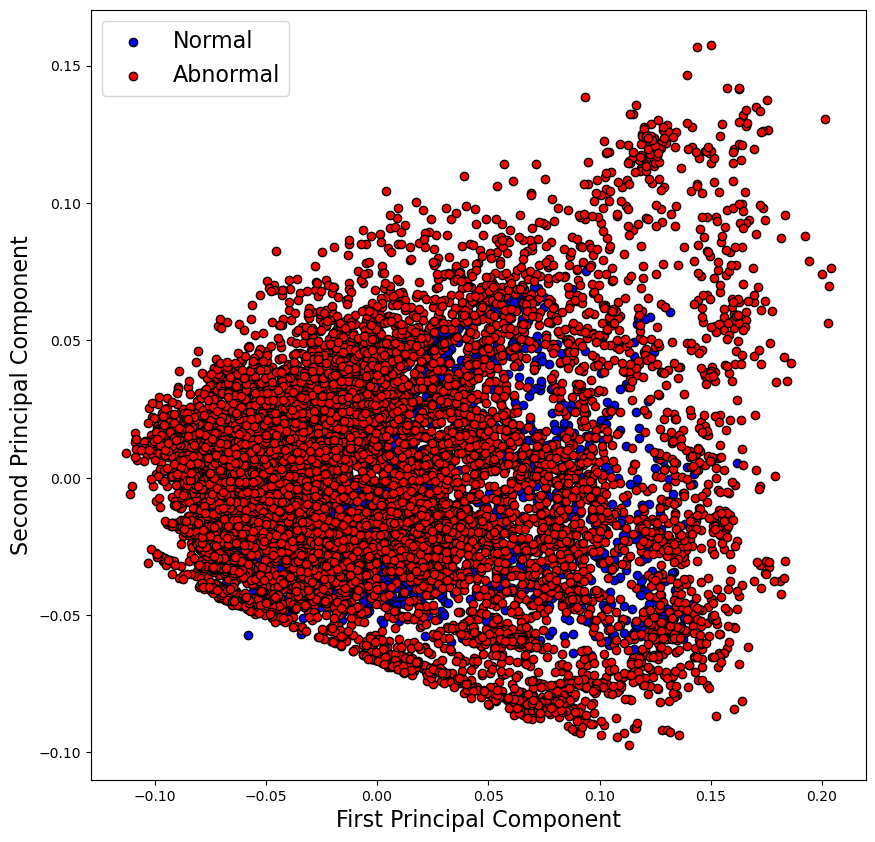

In [29]:
%matplotlib inline

# Find the first 2 principal components for both the datasets
pca5 = KernelPCA(kernel="sigmoid", n_components=3, random_state=0)
normal_pca = pca5.fit_transform(normal_pca_array)
pca6 = KernelPCA(kernel="sigmoid", n_components=3, random_state=0)
abnormal_pca = pca6.fit_transform(abnormal_pca_array)

# Figure size
plt.figure(figsize=(10,10))

colors = ['b', 'c', 'y', 'm', 'r']

# Plot the first two components
normal = plt.scatter(normal_pca[:, 0], normal_pca[:, 1], edgecolors='#000000', label="normal", color=colors[0])
abnormal = plt.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], edgecolors='#000000', label="abnormal", color=colors[4])
plt.xlabel("First Principal Component", fontsize=16)
plt.ylabel("Second Principal Component", fontsize=16)
plt.legend((normal, abnormal),
           ('Normal', 'Abnormal'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=16)

# Show the plot
plt.show()

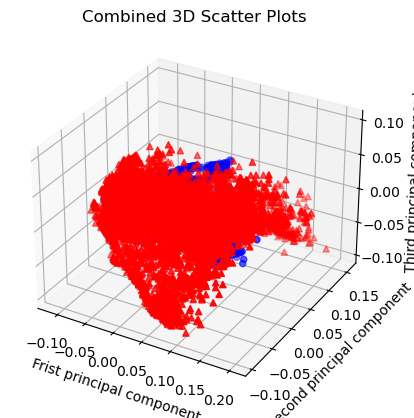

In [30]:
%matplotlib inline

#### %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

# create two 3D scatter plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o') #, marker='o'
ax.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], abnormal_pca[:, 2], c='r', marker='^') #, marker='^'

# set the axis labels
ax.set_xlabel('Frist principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# set the plot title
ax.set_title('Combined 3D Scatter Plots')

# show the plot
plt.show()

# COSINE PCA

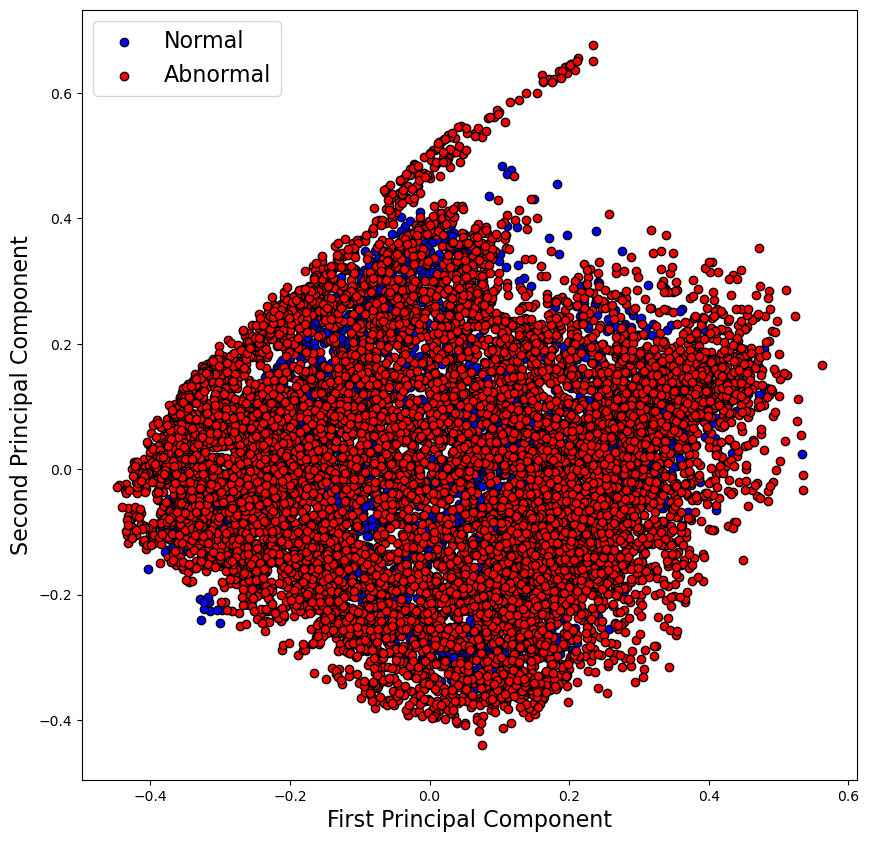

In [31]:
%matplotlib inline

# Find the first 2 principal components for both the datasets
pca7 = KernelPCA(kernel="cosine", n_components=3, random_state=0)
normal_pca = pca7.fit_transform(normal_pca_array)
pca8 = KernelPCA(kernel="cosine", n_components=3, random_state=0)
abnormal_pca = pca8.fit_transform(abnormal_pca_array)

# Figure size
plt.figure(figsize=(10,10))

colors = ['b', 'c', 'y', 'm', 'r']

# Plot the first two components
normal = plt.scatter(normal_pca[:, 0], normal_pca[:, 1], edgecolors='#000000', label="normal", color=colors[0])
abnormal = plt.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], edgecolors='#000000', label="abnormal", color=colors[4])
plt.xlabel("First Principal Component", fontsize=16)
plt.ylabel("Second Principal Component", fontsize=16)
plt.legend((normal, abnormal),
           ('Normal', 'Abnormal'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=16)

# Show the plot
plt.show()

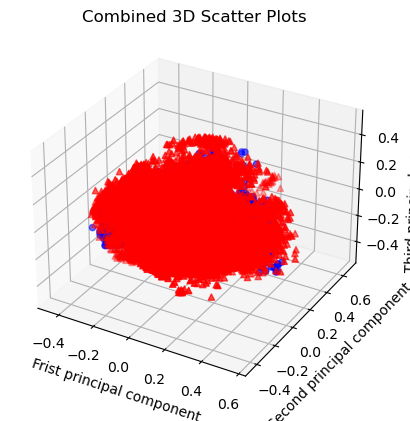

In [32]:
%matplotlib inline

#### %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

# create two 3D scatter plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o') #, marker='o'
ax.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], abnormal_pca[:, 2], c='r', marker='^') #, marker='^'

# set the axis labels
ax.set_xlabel('Frist principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# set the plot title
ax.set_title('Combined 3D Scatter Plots')

# show the plot
plt.show()

# POLY PCA

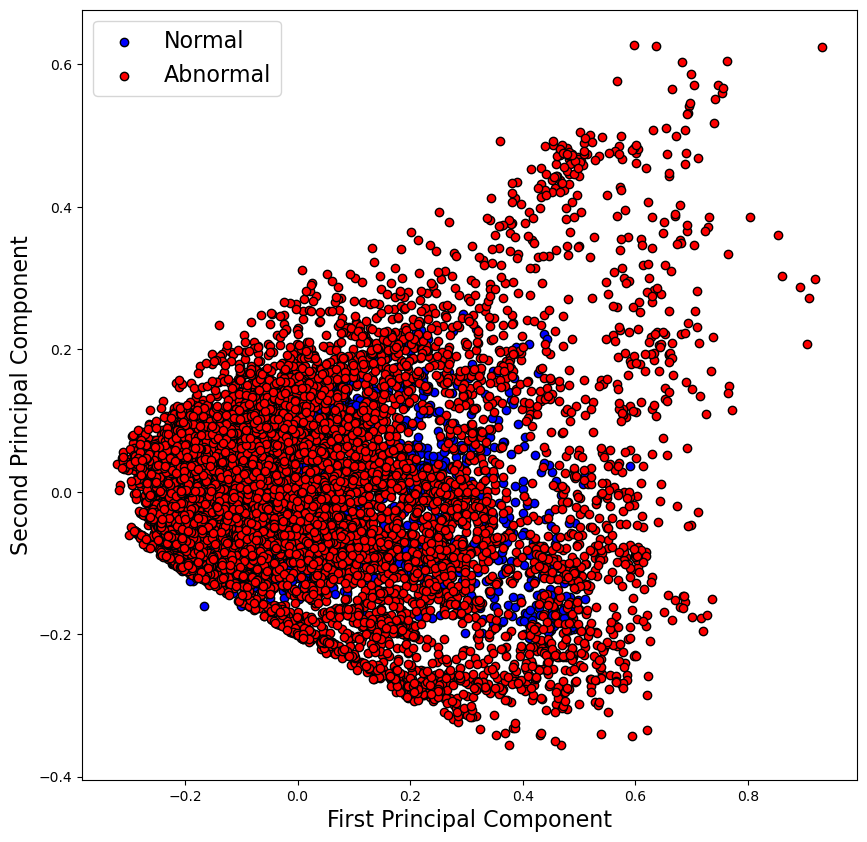

In [33]:
%matplotlib inline

# Find the first 2 principal components for both the datasets
pca9 = KernelPCA(kernel="poly", n_components=3, random_state=0)
normal_pca = pca9.fit_transform(normal_pca_array)
pca10 = KernelPCA(kernel="poly", n_components=3, random_state=0)
abnormal_pca = pca10.fit_transform(abnormal_pca_array)

# Figure size
plt.figure(figsize=(10,10))

colors = ['b', 'c', 'y', 'm', 'r']

# Plot the first two components
normal = plt.scatter(normal_pca[:, 0], normal_pca[:, 1], edgecolors='#000000', label="normal", color=colors[0])
abnormal = plt.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], edgecolors='#000000', label="abnormal", color=colors[4])
plt.xlabel("First Principal Component", fontsize=16)
plt.ylabel("Second Principal Component", fontsize=16)
plt.legend((normal, abnormal),
           ('Normal', 'Abnormal'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=16)

# Show the plot
plt.show()

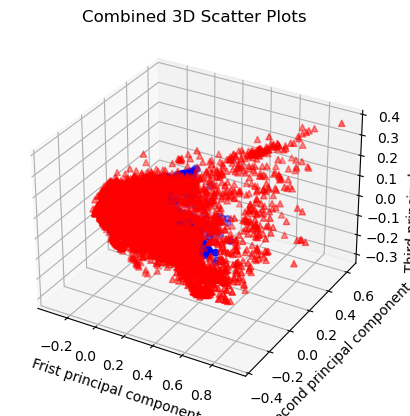

In [34]:
%matplotlib inline

#### %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

# create two 3D scatter plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o') #, marker='o'
ax.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], abnormal_pca[:, 2], c='r', marker='^') #, marker='^'

# set the axis labels
ax.set_xlabel('Frist principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# set the plot title
ax.set_title('Combined 3D Scatter Plots')

# show the plot
plt.show()

# tSNE

In [35]:
# tSNE needs the full data set
full_data = pd.concat([normal_df, abnormal_df], ignore_index=True)
full_data.rename(columns={187:'class'}, inplace=True)
full_data_noclass = full_data.drop(columns=['class'])

In [40]:
from sklearn.manifold import TSNE

# Separate the features and labels
X = full_data_noclass
y = full_data['class']

# Fit the t-SNE model
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, verbose=1, random_state=123)
X_tsne = tsne.fit_transform(X)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14552 samples in 0.016s...
[t-SNE] Computed neighbors for 14552 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14552
[t-SNE] Computed conditional probabilities for sample 2000 / 14552
[t-SNE] Computed conditional probabilities for sample 3000 / 14552
[t-SNE] Computed conditional probabilities for sample 4000 / 14552
[t-SNE] Computed conditional probabilities for sample 5000 / 14552
[t-SNE] Computed conditional probabilities for sample 6000 / 14552
[t-SNE] Computed conditional probabilities for sample 7000 / 14552
[t-SNE] Computed conditional probabilities for sample 8000 / 14552
[t-SNE] Computed conditional probabilities for sample 9000 / 14552
[t-SNE] Computed conditional probabilities for sample 10000 / 14552
[t-SNE] Computed conditional probabilities for sample 11000 / 14552
[t-SNE] Computed conditional probabilities for sample 12000 / 14552
[t-SNE] Computed conditional probabilities for sam

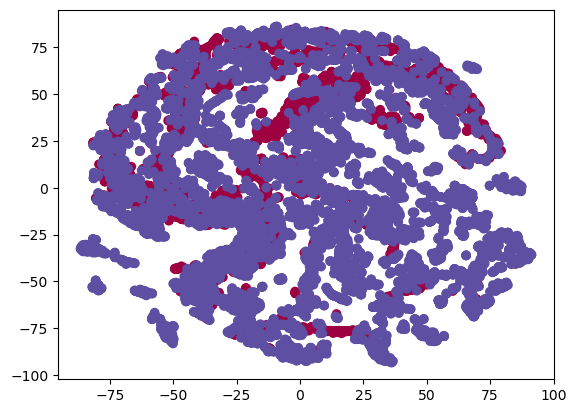

In [41]:
# Visualize the results
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = cmap(norm(y)))
plt.show()

# Fourier transform

In [264]:
# define a custom function to apply Fourier Transform on a row of the DataFrame
def fft_row(row):
    fft_coeff = np.fft.rfft(row)
    list_element = fft_coeff.tolist()
    return list_element

normal_coeffs = list()
for i in range(normal_df_noclass.shape[0]):
    normal_coeffs.append(fft_row(normal_df_noclass.iloc[i]))

abnormal_coeffs = list()
for i in range(abnormal_df_noclass.shape[0]):
    abnormal_coeffs.append(fft_row(abnormal_df_noclass.iloc[i]))

In [267]:
normal_df_fft = pd.DataFrame(normal_coeffs)
abnormal_df_fft = pd.DataFrame(abnormal_coeffs)
normal_df_fft

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,22.291734+0.000000j,-1.674230-8.376171j,2.641644-5.886204j,-2.032958+2.039577j,0.546116-0.397914j,5.505019+2.199464j,2.155636-2.939126j,3.055871-2.037143j,-1.765618-1.423374j,3.526175+1.059679j,...,0.369475-0.207407j,0.401720-0.008757j,0.358306-0.223010j,0.543740+0.069470j,0.221424-0.162584j,0.605510-0.112571j,0.246148+0.089228j,0.458595-0.227404j,0.379061+0.142055j,0.386760-0.136072j
1,44.625850+0.000000j,-3.983493-12.956112j,1.860824-15.283314j,-0.221293-0.802203j,-5.017426-0.161988j,0.983302-0.042166j,3.468415+0.187802j,3.671342-0.945682j,-1.365352-1.955692j,1.344073-4.033844j,...,0.486309+0.020148j,0.255801-0.075704j,0.500254-0.293143j,0.605957-0.104574j,0.307537+0.159292j,0.241810-0.300389j,0.743254+0.009570j,0.400045+0.115731j,0.280366-0.081292j,0.548956-0.192275j
2,30.579898+0.000000j,-0.611478+2.178899j,-5.872958-3.970494j,-1.819369-3.350248j,2.364861+0.990227j,3.444346+1.218515j,2.553701-2.371538j,2.887011-3.701730j,3.890132+0.740278j,0.256521+3.885489j,...,0.296799+0.001266j,0.216920-0.081347j,0.299784-0.231898j,0.374261-0.209157j,0.437669-0.188037j,0.499251-0.155373j,0.507204+0.032072j,0.405081+0.095778j,0.305852+0.101874j,0.231830+0.048260j
3,13.749002+0.000000j,0.879491-1.806628j,-2.445450-5.134145j,1.455126-1.588167j,1.382107+3.589972j,0.575900+2.018916j,2.738901-2.755325j,4.683728-2.138585j,-0.102393+1.373565j,-2.359468-1.451639j,...,0.639712-0.230086j,0.674431-0.004285j,0.482410-0.085285j,0.522737-0.187453j,0.592878-0.072276j,0.608820+0.024415j,0.436007-0.062350j,0.573789-0.073425j,0.633760+0.053329j,0.554966+0.074178j
4,19.065050+0.000000j,0.861906-2.865197j,-2.241383-5.672882j,1.661862-2.763460j,2.817669+2.999303j,1.455246+2.581519j,2.081937-3.191220j,4.369781-4.180743j,1.955175+1.370108j,-2.356970+0.651326j,...,0.553333-0.270658j,0.359998-0.013667j,0.116953-0.049351j,0.368863-0.246819j,0.421284-0.113650j,0.323300+0.039009j,0.238401-0.100086j,0.311012-0.183147j,0.391843-0.035266j,0.212693+0.165327j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,27.666272+0.000000j,1.288764-2.497732j,-4.903046-4.646859j,0.836130-3.381251j,4.096503+1.232350j,4.109383+1.164183j,2.060176-3.298260j,2.508787-4.354901j,3.764730+0.831891j,-0.389836+2.521540j,...,0.429690+0.017360j,0.200421-0.003865j,0.291432-0.215458j,0.417862-0.230270j,0.346382-0.070781j,0.393586-0.107559j,0.448918-0.042729j,0.450224+0.015151j,0.372724+0.117679j,0.291626+0.065575j
4042,13.598930+0.000000j,0.547711-2.621636j,1.109832-6.866318j,0.296585+2.279927j,-0.985408-0.747405j,4.647850+1.999844j,0.444619-0.657996j,4.676553-3.337130j,-0.702881+2.056719j,0.342686-3.375001j,...,0.492761-0.111972j,0.428759-0.097310j,0.593755-0.182789j,0.515467+0.029755j,0.403144-0.107722j,0.526030-0.079726j,0.538189-0.025651j,0.515857+0.013851j,0.424068-0.021324j,0.544227-0.114159j
4043,34.695990+0.000000j,-3.845429-8.310831j,0.130783-10.527439j,0.785976+0.306984j,-0.341253+2.332730j,3.064110-0.073467j,4.541039-0.995791j,1.579862-4.279641j,3.282053-0.653785j,-2.966939+0.411433j,...,0.776034-0.487507j,0.143146+0.345926j,0.025468-0.219670j,0.891919-0.159734j,0.301221+0.108511j,0.390205-0.130158j,0.284713+0.043178j,0.380900+0.005747j,0.799998+0.041472j,0.330546+0.200749j
4044,27.538461+0.000000j,-3.869087-9.724553j,4.601716-6.347794j,-1.556781+0.536361j,-1.015301-3.135484j,2.923102+1.644026j,0.273157-0.797912j,3.659536-0.737422j,-0.030743-2.138369j,2.554524-0.359560j,...,0.586919-0.311961j,0.742939+0.147363j,0.448871-0.102169j,0.701357-0.032835j,0.564081-0.027597j,0.651601+0.034268j,0.490355-0.072022j,0.797865-0.014544j,0.430472+0.120432j,0.687938-0.216085j


In [268]:
abnormal_df_fft

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,39.637706+0.000000j,17.049156-26.717681j,-5.302746-11.725068j,5.458021+0.518222j,8.950322-10.389461j,-2.038356-10.050680j,-0.625791-2.330099j,1.876622-5.189000j,-2.879940-3.647636j,0.479426+1.758056j,...,0.206540-0.401503j,0.334489+0.179794j,0.724857-0.175026j,0.182177-0.276378j,0.370795+0.345192j,0.920847-0.076164j,0.372415-0.427916j,0.305491+0.096846j,0.675281-0.171583j,0.107908-0.345659j
1,24.199354+0.000000j,0.5903590-3.8039580j,-1.395578-8.502125j,2.476262-1.830558j,0.086317+1.693584j,2.437023-0.617479j,4.702959+0.932581j,0.084043-3.420298j,3.579328-4.518379j,1.542254+1.861436j,...,0.496187-0.158670j,0.961844-0.323921j,0.485065+0.653068j,0.139839-0.424236j,1.147450-0.045421j,0.654599-0.007973j,0.554905-0.073487j,0.427764+0.165804j,0.737457-0.059289j,0.653632-0.293658j
2,52.144393+0.000000j,5.629383-32.474345j,1.527458-1.787666j,4.576406-11.870112j,0.405361-3.107707j,2.014686-6.932124j,0.545937-1.251008j,2.888411-5.033129j,0.849958-2.228073j,1.200620-4.698929j,...,0.400749-0.367415j,0.669955+0.125690j,0.346687-0.326468j,0.617019+0.205734j,0.404145-0.315117j,0.508194+0.278386j,0.585377-0.145306j,0.675244+0.067758j,0.344473-0.306793j,0.561964+0.347319j
3,36.390943+0.000000j,-1.675810-19.375088j,5.367770-2.788401j,-4.000091-6.690194j,2.469452-0.835670j,-1.224017-1.743153j,1.410146-1.844431j,0.775522+0.837464j,0.763889-3.370059j,1.134328+2.070797j,...,0.586240-0.055135j,0.136234-0.178783j,0.519783-0.080325j,0.168750-0.039568j,0.544020-0.148783j,0.180929-0.021354j,0.437207-0.156306j,0.251974+0.063599j,0.356066-0.185722j,0.277174+0.127164j
4,14.881620+0.000000j,10.649205-7.016093j,4.701942-6.670152j,3.610985-4.358866j,3.118239-4.615714j,1.141971-3.572186j,1.745715-1.133927j,3.901179-1.592048j,3.497148-3.545446j,1.878987-3.558464j,...,0.558599-0.149605j,0.378070-0.174206j,0.422530+0.033426j,0.625760-0.061067j,0.503933-0.234202j,0.391476-0.126219j,0.459404-0.127469j,0.314079-0.181029j,0.241347+0.063093j,0.505328+0.128262j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,26.034323+0.000000j,3.080898-10.975151j,1.860420-8.572528j,0.321529-0.586213j,-1.121565-1.449612j,4.552727-0.670598j,1.741583+0.327954j,2.711907-4.987686j,1.866778+1.059832j,-0.706091-2.793031j,...,0.334070-0.079999j,0.411077-0.199989j,0.370875-0.059020j,0.305889-0.116870j,0.375980-0.178909j,0.332049+0.032730j,0.275268-0.079473j,0.417814-0.027517j,0.340948-0.019376j,0.323162-0.037751j
10502,39.524194+0.000000j,6.879409-25.595358j,-0.884082-1.526643j,6.289405-8.496768j,-2.190455-2.172207j,7.441600-2.448025j,-0.261983-6.656643j,2.879680-0.351862j,2.047001-6.295918j,-0.823614-0.702299j,...,0.671728+0.111926j,0.164507-0.261027j,0.695071+0.363168j,0.501542-0.684831j,-0.061724+0.375381j,0.947776-0.050075j,0.087683-0.162520j,0.709337+0.144182j,0.154801-0.268111j,0.582365+0.444055j
10503,26.919851+0.000000j,-4.3581180+3.0273150j,-3.413564-4.062707j,7.290817-4.066401j,7.240586+3.152638j,-0.440638-0.513641j,2.661229-6.665355j,5.890080-0.168030j,-0.272668+2.177496j,-0.140166-3.744582j,...,0.510249-0.111060j,0.447044-0.142669j,0.516443-0.007804j,0.511211-0.080409j,0.683720-0.121994j,0.401512-0.006256j,0.461953-0.085540j,0.333612+0.069121j,0.498674+0.085187j,0.718267-0.046004j
10504,34.963166+0.000000j,-5.072987-12.281261j,7.173724-5.257091j,0.922016+1.549418j,3.144142-6.140333j,4.628769-0.112264j,0.122399-4.580201j,3.472954-0.603013j,0.334584-2.805625j,4.571342-0.223056j,...,0.448622-0.158664j,0.316250-0.103129j,0.319222-0.275867j,0.490961+0.026044j,0.147490-0.124889j,0.578579-0.159931j,0.236620+0.059009j,0.354071-0.185695j,0.376832+0.016966j,0.304637-0.005940j


In [269]:
normal_fft_pca_array = normal_df_fft.to_numpy()
abnormal_fft_pca_array = abnormal_df_fft.to_numpy()

# SVD on FFT

In [ ]:
def pca(X):
    mean = X.mean(axis=0) 
    center = X - mean 
    _, stds, pcs = np.linalg.svd(center/np.sqrt(X.shape[0])) 

    return stds**2, pcs

In [271]:
class ComplexPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.u = self.s = self.components_ = None
        self.mean_ = None

    @property
    def explained_variance_ratio_(self):
        return self.s

    def fit(self, matrix, use_gpu=False):
        self.mean_ = matrix.mean(axis=0)
        if use_gpu:
            import tensorflow as tf  # torch doesn't handle complex values.
            tensor = tf.convert_to_tensor(matrix)
            u, s, vh = tf.linalg.svd(tensor, full_matrices=False)  # full=False ==> num_pc = min(N, M)
            # It would be faster if the SVD was truncated to only n_components instead of min(M, N)
        else:
            _, self.s, vh = np.linalg.svd(matrix, full_matrices=False)  # full=False ==> num_pc = min(N, M)
            # It would be faster if the SVD was truncated to only n_components instead of min(M, N)
        self.components_ = vh  # already conjugated.
        # Leave those components as rows of matrix so that it is compatible with Sklearn PCA.

    def transform(self, matrix):
        data = matrix - self.mean_
        result = data @ self.components_.T
        return result

    def inverse_transform(self, matrix):
        result = matrix @ np.conj(self.components_)
        return self.mean_ + result


In [274]:
pca_complex1 = ComplexPCA(3)
pca_complex1 = ComplexPCA(3)

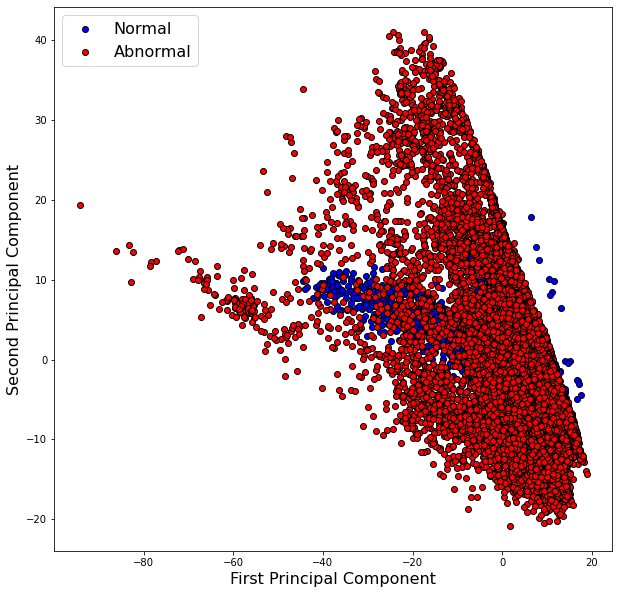

In [275]:
%matplotlib inline

# Find the first 2 principal components for both the datasets
pca_complex1.fit(normal_fft_pca_array)
normal_pca = pca_complex1.transform(normal_fft_pca_array)

pca_complex2.fit(abnormal_fft_pca_array)
abnormal_pca = pca_complex2.transform(abnormal_fft_pca_array)

# Figure size
plt.figure(figsize=(10,10))

colors = ['b', 'c', 'y', 'm', 'r']

# Plot the first two components
normal = plt.scatter(normal_pca[:, 0], normal_pca[:, 1], edgecolors='#000000', label="normal", color=colors[0])
abnormal = plt.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], edgecolors='#000000', label="abnormal", color=colors[4])
plt.xlabel("First Principal Component", fontsize=16)
plt.ylabel("Second Principal Component", fontsize=16)
plt.legend((normal, abnormal),
           ('Normal', 'Abnormal'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=16)

# Show the plot
plt.show()

<IPython.core.display.Javascript object>


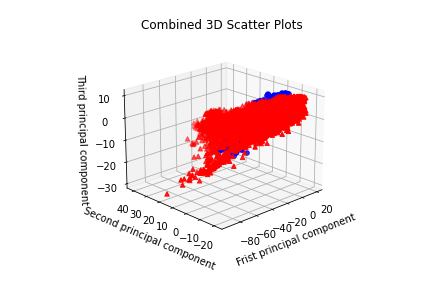

In [276]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

# create two 3D scatter plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o') #, marker='o'
ax.scatter(abnormal_pca[:, 0], abnormal_pca[:, 1], abnormal_pca[:, 2], c='r', marker='^') #, marker='^'

# set the axis labels
ax.set_xlabel('Frist principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

# set the plot title
ax.set_title('Combined 3D Scatter Plots')

# show the plot
plt.show()